# Required Libraries  

In [1]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Dense, GaussianNoise,Lambda
from keras.models import Model
from keras import backend as K
%matplotlib inline
import matplotlib.pyplot as plt
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.constraints import max_norm 
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(3)                                                 
from scipy import interpolate
from sklearn.manifold import TSNE


# Parameters Declaration 
Lenght of Message space, Number of bits per symbol, number of channel uses
and Rate of communication is defined here. 

In [2]:
L_o_m  = 256                                     # Lenght of Message space(M) given by 2^number of bits 
bits = np.log2(L_o_m)                            # Number of bits 
bits = int(bits)                                 # Converting it to int 
n = 8                                            # Number of channels(n) 
R = bits/n                                       # Communication rate(R) given by number of bits divided by number of channels 

print ('Lenght of Message space (M):',L_o_m,'Number of bits (k):',bits,'Number of channels (n):',n)

Lenght of Message space (M): 256 Number of bits (k): 8 Number of channels (n): 8


# Generating training data

In [3]:
samples = 100000
labels = np.random.randint(L_o_m , size=samples)        # generating N random numbers whose values are enclosed between 0 and (M-1)

# Performing Onehot Encoding
Each of the message in generated message space is onehot encoded. 

In [4]:
training_data = []                              # Creating a empty list 
for i in labels:                         
    inp_vector = np.zeros(L_o_m)                # Creating a numpy array of size M                                                    
    inp_vector[i] = 1                           # Performing one hot encoding 
    training_data.append(inp_vector) 



In [5]:
training_data = np.array(training_data)         # Transforming data to numpy array
print (training_data.shape)                     # Each of the sample out of the N generated samples is onehot encoded to vector of size M 

(100000, 256)


Verifying the one hot encoding performed on the generated data.  


In [6]:
check_list = [23,45,97]
for i in check_list:
    print(labels[i],training_data[i])

142 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Defining the architecture of Autoencoder

In [7]:
input_signal = Input(shape=(L_o_m,))                     # After performing one hot encoding each input is vector of size M
encoded1 = Dense(L_o_m, activation='relu')(input_signal) # First layer is dense layer with relu activation function and M nuerons  
encoded2 = Dense(n, activation='linear')(encoded1)       # Second layer is dense layer with linear activaton function and n_channel nuerons 

encoded3 = BatchNormalization()(encoded2)                # encoded3 = Lambda(lambda x: np.sqrt(n)*K.l2_normalize(x,axis=1))(encoded2)     
                                                         # Normalisation is performed to met the physical constraints (Energy Constraint)


EbNo_train = 5.01187                                     # coverted 7 db of EbNo
                                                         # 10log(EbNo) = 7 db
encoded4 = GaussianNoise(np.sqrt(1/(2*R*EbNo_train)))(encoded3)                 
                                                         # As Variance is given by (1/(2*R*EbNo_train) 
                                                         # Gausian noise is added by this layer 

decoded1 = Dense(L_o_m, activation='relu')(encoded4)     # First layer of the decoder is dense layer with-
                                                         #-relu activation function and total M nuerons

decoded2 = Dense(L_o_m, activation='softmax')(decoded1)  # Second layer of the decoder is dense layer with-
                                                         #-softmax activation function which outputs the probabilities 


autoencoder = Model(input_signal, decoded2)              # Autoencoder model is defined here 
adam = Adam(learning_rate=0.001)                         # Adam optimizer is used with learning rate 0.01 to minimise the loss 

autoencoder.compile(optimizer=adam, loss='categorical_crossentropy')            
                                                         # Autoencoder is compiled here and loss is defined as categorical crossentropy-
                                                         #-between the onehot encoded input vector and the output of the decoder 

# Summary of Autoencoder

In [8]:
print (autoencoder.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 dense (Dense)               (None, 256)               65792     
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
 batch_normalization (BatchN  (None, 8)                32        
 ormalization)                                                   
                                                                 
 gaussian_noise (GaussianNoi  (None, 8)                0         
 se)                                                             
                                                                 
 dense_2 (Dense)             (None, 256)               2304  

# Generating validation data 

In [9]:
v_samples = 10000                                    # Size of validation samples 
                                                     
v_labels = np.random.randint(L_o_m,size=v_samples)   # Validation data of size N is created with all values enclosed between 0 and M
v_data = []

for i in v_labels:
    v_vector = np.zeros(L_o_m)                       # Numpy array of size M is created with all entries equal to zero 
    v_vector[i] = 1                                  # performing One hot encoding on each entry of v_samples 
    v_data.append(v_vector)
    
v_data = np.array(v_data)                            # v_samples data is converted to numpy array 
print(v_data.shape)                                  # Shape of test_data is given by (v_samples*M)

(10000, 256)


In [10]:
test_num = 89                                        # Verifying the onehot encoding on generated test data 
print (v_data[test_num],v_labels[test_num])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 17


# Training the model 

In [11]:
# Autoencoder is fitted with the generated data 
autoencoder.fit(training_data, training_data, epochs=20, batch_size=300,validation_data=(v_data, v_data))                                           

Epoch 1/20
334/334 [==============================] - 9s 21ms/step - loss: 1.3664 - val_loss: 0.0464
Epoch 2/20
334/334 [==============================] - 6s 18ms/step - loss: 0.0284 - val_loss: 0.0025
Epoch 3/20
334/334 [==============================] - 6s 17ms/step - loss: 0.0094 - val_loss: 8.3900e-04
Epoch 4/20
334/334 [==============================] - 6s 18ms/step - loss: 0.0048 - val_loss: 3.7970e-04
Epoch 5/20
334/334 [==============================] - 6s 19ms/step - loss: 0.0029 - val_loss: 2.0511e-04
Epoch 6/20
334/334 [==============================] - 4s 11ms/step - loss: 0.0020 - val_loss: 1.2687e-04
Epoch 7/20
334/334 [==============================] - 4s 11ms/step - loss: 0.0014 - val_loss: 7.6769e-05
Epoch 8/20
334/334 [==============================] - 4s 11ms/step - loss: 0.0011 - val_loss: 5.0475e-05
Epoch 9/20
334/334 [==============================] - 4s 11ms/step - loss: 8.0924e-04 - val_loss: 3.0824e-05
Epoch 10/20
334/334 [==============================] - 4s 1

# Encoder

In [12]:
encoder = Model(input_signal, encoded3)                   # Model of Encoder is Defined here  

# Decoder 

In [13]:
encoded_input = Input(shape=(n,))                         # Model for decoder is defined here  

decoder_1 = autoencoder.layers[-2](encoded_input)         # Second last layer of the defined Autoencoder 
decoder_2 = autoencoder.layers[-1](decoder_1)             # Last layer of the defined Autoencoder 
decoder = Model(encoded_input, decoder_2)                                 

# Generating Test data

In [14]:
test_samples = 1500                                       # Size of test samples 
                                                                               
test_labels = np.random.randint(L_o_m,size=test_samples)  # Test data of size N is created with all values enclosed between 0 and M
test_data = []

for i in test_labels:
    test_vector = np.zeros(L_o_m)                         # Numpy array of size M is created with all entries equal to zero 
    test_vector[i] = 1                                    # performing One hot encoding on each entry of test_samples  
    test_data.append(test_vector)
    
test_data = np.array(test_data)                           # Test data is converted to numpy array 
print(test_data.shape)                                    # Shape of test_data is given by (1500*M)

(1500, 256)


In [15]:
test_num = 99                                             # Verifying the onehot encoding on generated test data 
print (test_data[test_num],test_labels[test_num])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 244


# Constellation Diagram
Every message in the message space is encode to draw constellation diagram 

In [16]:
scatter_plot = []                                                                
for i in range(0,L_o_m):                                  # For all the messages in the message space 
    array1 = np.zeros(L_o_m)
    
    array1[i] = 1                                         # onehot encoding of the each message
    scatter_plot.append(encoder.predict(np.expand_dims(array1,axis=0)))        
                                                          # Encoding every possible entry of Messages needed to be sent 
scatter_plot = np.array(scatter_plot)                     # As you can see for each of the sixteen possible values there is a complex representation 
print (scatter_plot.shape)

(256, 1, 8)


/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


(1500, 2)


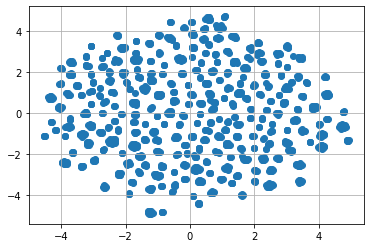

In [17]:
test_encoded = encoder.predict(test_data)                 # Test data is subjected to encoder 
noise_std = np.sqrt(1/(2*R*EbNo_train))                   # Standard deviation of noise with respect to given SNR
noise = noise_std * np.random.randn(test_samples,n)       # Generating noise 
test_encoded = test_encoded + noise                       # Noise is added 

T1 = TSNE(learning_rate= 'auto' , n_components=2,n_iter=35000, random_state=0, perplexity=50).fit_transform(test_encoded)        
                                                          # Noise added vector subjected to t-distributed stochastic neighbor embedding (t-SNE)
                                                          # t-distributed stochastic neighbor embedding (t-SNE) is a statistical method for 
                                                          # visualizing high-dimensional data by giving each datapoint a location 
                                                          # in a two or three-dimensional map.

print (T1.shape)
T1 = T1 / 8                                               # eight channels 

plt.scatter(T1[:,0],T1[:,1])
 
plt.grid()
plt.show()

# Calculating Bit Error Rate 

In [18]:
def frange(i, j, jump):                                   # For represnting SNR after overy 0.5 db interval 
  while i < j:
    yield i
    i += jump

In [19]:
SNR_range = list(frange(-4,8.5,0.5))                      # Range of SNR 
print(len(SNR_range))                                     # In total there are 25 intervals
  
BER = [None]*len(SNR_range)                                                  
                                                 
for x in range(0,len(SNR_range)):                         # for each of the value of SNR 
    EbNo=10.0**(SNR_range[x]/10.0)                        # to covert each value of SNR from db's
    noise_std = np.sqrt(1/(2*R*EbNo))                     # Standard deviation of the added noise layer 
    mean = 0                                              # Mean of the added noise layer 
    errors = 0
    
    noise = noise_std * np.random.randn(test_samples,n)   # Noise is added to encoded data
    encoded_vector = encoder.predict(test_data)           # Encoded test data 
    noise_added_vector = encoded_vector + noise           # Encoded test data + Noise

    decoded_vector =  decoder.predict(noise_added_vector) # Decoded data 
    pred_output = np.argmax(decoded_vector,axis=1)        # As the decoder last layer is Softmax so the index with the highest probabilty is chosen
    errors = (pred_output != test_labels)                 # It checks for each of the test_sample is the predicted value is same as the original value 
    
    errors =  errors.astype(int).sum()                    # Adds up the total Error bits in each of the iteration for N values  
        
    BER[x] = errors / test_samples                        # BER is given by total  wrongly identified examples over total number of Examples

    print ('SNR (Signal to noise ratio):',SNR_range[x],'BER (Bit Error Rate):',BER[x])

25
SNR (Signal to noise ratio): -4 BER (Bit Error Rate): 0.43466666666666665
SNR (Signal to noise ratio): -3.5 BER (Bit Error Rate): 0.384
SNR (Signal to noise ratio): -3.0 BER (Bit Error Rate): 0.31333333333333335
SNR (Signal to noise ratio): -2.5 BER (Bit Error Rate): 0.2853333333333333
SNR (Signal to noise ratio): -2.0 BER (Bit Error Rate): 0.23466666666666666
SNR (Signal to noise ratio): -1.5 BER (Bit Error Rate): 0.17066666666666666
SNR (Signal to noise ratio): -1.0 BER (Bit Error Rate): 0.13
SNR (Signal to noise ratio): -0.5 BER (Bit Error Rate): 0.09866666666666667
SNR (Signal to noise ratio): 0.0 BER (Bit Error Rate): 0.06933333333333333
SNR (Signal to noise ratio): 0.5 BER (Bit Error Rate): 0.05466666666666667
SNR (Signal to noise ratio): 1.0 BER (Bit Error Rate): 0.024666666666666667
SNR (Signal to noise ratio): 1.5 BER (Bit Error Rate): 0.017333333333333333
SNR (Signal to noise ratio): 2.0 BER (Bit Error Rate): 0.013333333333333334
SNR (Signal to noise ratio): 2.5 BER (Bit E

# Plot of Bit Error Rate against Range of SNR

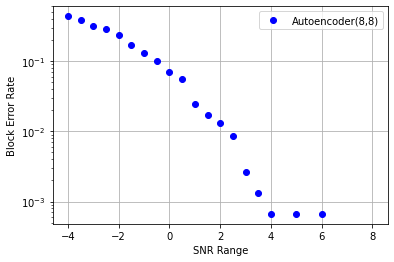

In [20]:

plt.plot(SNR_range, BER, 'bo',label='Autoencoder(8,8)')
plt.yscale('log')
plt.xlabel('SNR Range')
plt.ylabel('Block Error Rate')
plt.grid()
plt.legend(loc='upper right',ncol = 1)